In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from keras.layers import Input

import cv2
import shutil
import glob
import os

In [30]:
base_path='../input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/train'
filepaths=[]
labels=[]
for (dir_path, dir_names, file_names) in os.walk(base_path):
    for i in file_names:
        filepaths.append(dir_path+'/'+i)
        if 'healthy' in (i.split('_')):
            labels.append("No")
        else: 
            labels.append("Yes")
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  12009    labels:  12009


In [31]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(12009,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,../input/potato-tomato-dataset/idata/Image Dat...,No
1,../input/potato-tomato-dataset/idata/Image Dat...,No
2,../input/potato-tomato-dataset/idata/Image Dat...,No
3,../input/potato-tomato-dataset/idata/Image Dat...,No
4,../input/potato-tomato-dataset/idata/Image Dat...,No


In [32]:
print(df['labels'].value_counts())

Yes    7998
No     4011
Name: labels, dtype: int64


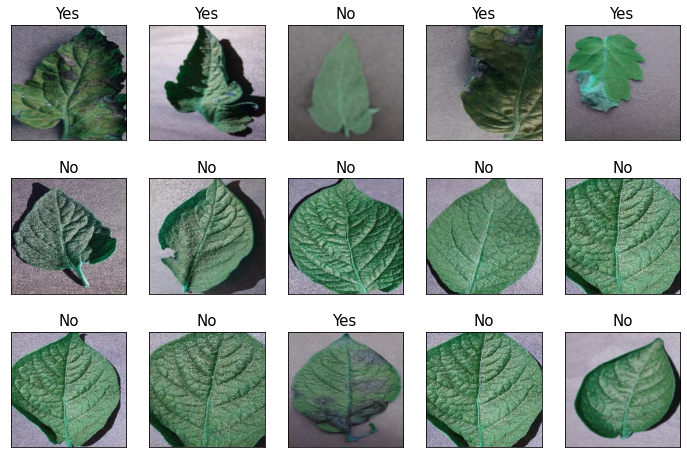

In [33]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [34]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.70, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (7145, 2)
test set shape: (3603, 2)
validation set shape: (1261, 2)


In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [36]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 7145 validated image filenames belonging to 2 classes.
Found 1261 validated image filenames belonging to 2 classes.
Found 3603 validated image filenames belonging to 2 classes.


In [37]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [38]:
input_data = Input(shape=(200,200,3), name='input')

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_611 (Bat (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
Non-trainable params: 60,800
_____________________________________

In [39]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Leaf_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
),tf.keras.metrics.Precision( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.Recall( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = [callbacks], verbose = 1)

Epoch 1/40
447/447 [==============================] - 109s 201ms/step - loss: 0.1643 - accuracy: 0.9366 - auc_3: 0.9845 - precision_3: 0.9660 - recall_3: 0.9372 - true_positives_3: 4431.0000 - true_negatives_3: 2261.0000 - false_positives_3: 156.0000 - false_negatives_3: 297.0000 - val_loss: 5.5861 - val_accuracy: 0.9873 - val_auc_3: 0.9976 - val_precision_3: 0.9940 - val_recall_3: 0.9869 - val_true_positives_3: 830.0000 - val_true_negatives_3: 415.0000 - val_false_positives_3: 5.0000 - val_false_negatives_3: 11.0000
Epoch 2/40
447/447 [==============================] - 86s 192ms/step - loss: 0.0420 - accuracy: 0.9878 - auc_3: 0.9985 - precision_3: 0.9919 - recall_3: 0.9896 - true_positives_3: 4679.0000 - true_negatives_3: 2379.0000 - false_positives_3: 38.0000 - false_negatives_3: 49.0000 - val_loss: 31.8392 - val_accuracy: 0.9944 - val_auc_3: 0.9937 - val_precision_3: 0.9952 - val_recall_3: 0.9964 - val_true_positives_3: 838.0000 - val_true_negatives_3: 416.0000 - val_false_positives

In [40]:
model.load_weights("Leaf_classifier_model.h5")
model.evaluate(test_gen)

226/226 [==============================] - 15s 65ms/step - loss: 11.6733 - accuracy: 0.9953 - auc_3: 0.9989 - precision_3: 0.9992 - recall_3: 0.9938 - true_positives_3: 2414.0000 - true_negatives_3: 1172.0000 - false_positives_3: 2.0000 - false_negatives_3: 15.0000


[11.673346519470215,
 0.9952816963195801,
 0.9989076852798462,
 0.9991722106933594,
 0.9938246011734009,
 2414.0,
 1172.0,
 2.0,
 15.0]

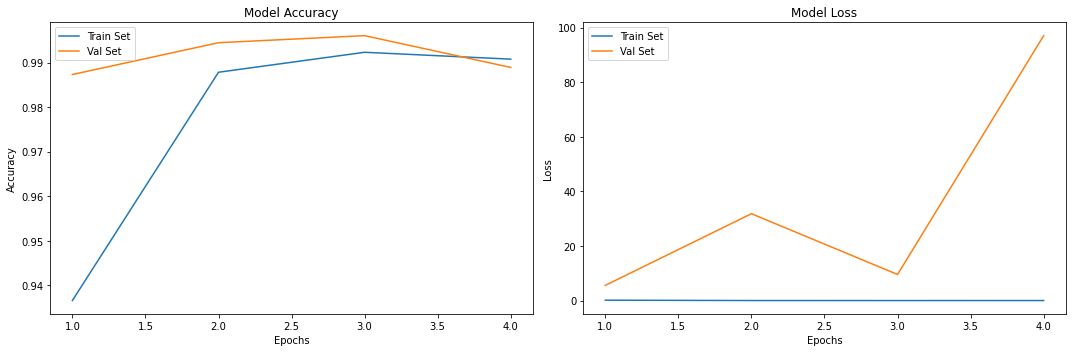

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()